In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

Code Adapted from: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH

## Helper Functions

In [2]:
def tsplot(y, lags=None, figsize=(20, 8), style='bmh', title='Time Series Analysis Plots'):
    # source: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=False, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, zero=False, auto_ylims=True)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Data Preparation

### Data Loading

In [3]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers = [f + '.JK' for f in lq45_tickers]
active_tickers.append('LQ45')

In [4]:
# Read downloaded stock Adjusted Close Price data
df_dict = {}
for ticker in tqdm(active_tickers):
    if ticker == 'LQ45':
        df_dict[ticker] = pd.read_csv(lq45_index_file)
    else:
        df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
    ## Take Only Date and Adjusted Close
    df_dict[ticker] = df_dict[ticker][['Date', 'Adj Close']]
    
    ## Convert Adj Close to Returns
    df_dict[ticker]['return'] = df_dict[ticker]['Adj Close'].pct_change()
    df_dict[ticker]['log_return'] = np.log(1 + df_dict[ticker]['return'])
    df_dict[ticker].drop('Adj Close', axis=1, inplace=True)

100%|███████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 93.84it/s]


In [5]:
# Do Some basic data Operations (Fill NaN, take only certain data range, generate in sample an dout of sample data)
date_start = '2009-01-01'
date_breakpoint = '2019-01-01'

nan_handle_method = 'drop'

in_df = {}
out_df = {}
rmv_tickers = []
for ticker in tqdm(active_tickers):
    # Fill NaN values with the earliest data
    if nan_handle_method == 'bfill':
        df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    elif nan_handle_method == 'drop':
        df_dict[ticker].dropna(inplace=True)
        
    # Take In Sample and Out Sample Data
    df_dict[ticker]['Date'] = pd.to_datetime(df_dict[ticker]['Date'])
    in_df[ticker] = df_dict[ticker][(df_dict[ticker]['Date'] >= date_start) & 
                                                (df_dict[ticker]['Date'] < date_breakpoint)]
    out_df[ticker] = df_dict[ticker][df_dict[ticker]['Date'] >= date_breakpoint]
    
    # Set Date as Index
    in_df[ticker] = in_df[ticker].reset_index(drop=True)
    in_df[ticker] = in_df[ticker].set_index('Date')
    out_df[ticker] = out_df[ticker].reset_index(drop=True)
    out_df[ticker] = out_df[ticker].set_index('Date')
    
    # Check if in_df is empty
    if len(in_df[ticker]['return']) < 252:
        rmv_tickers.append(ticker)

# Remove tickers that only have small amounts of data
active_tickers = [t for t in active_tickers if t not in rmv_tickers]

100%|██████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 171.88it/s]


### Plots

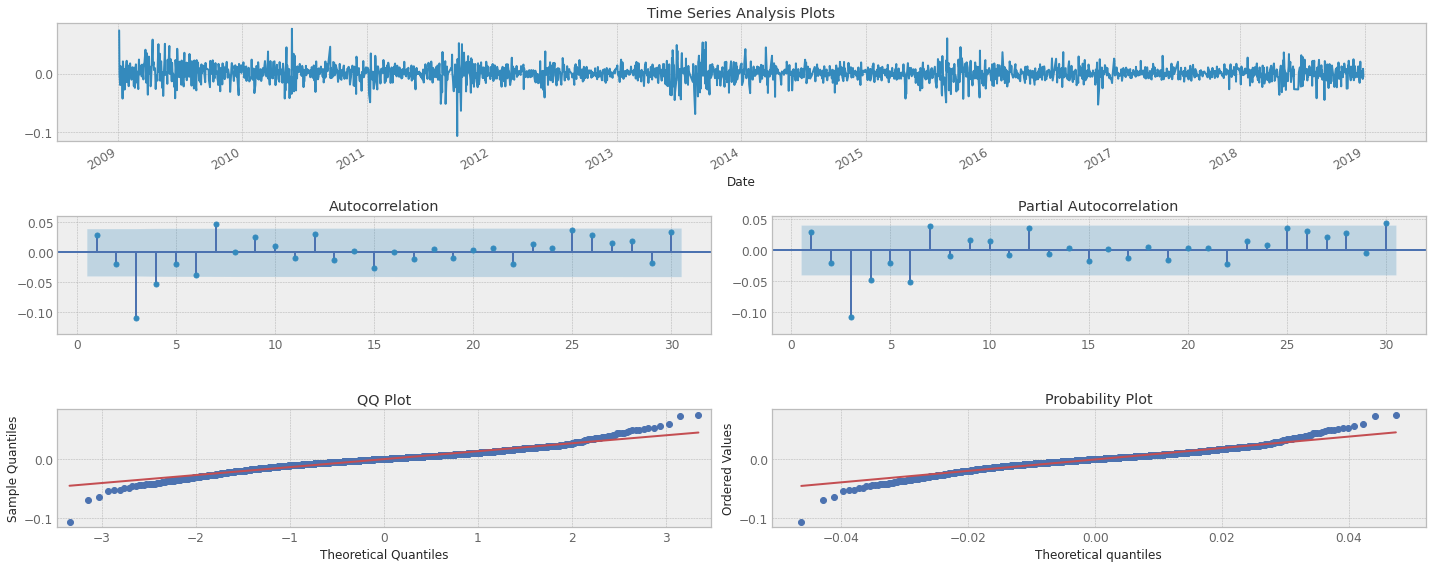

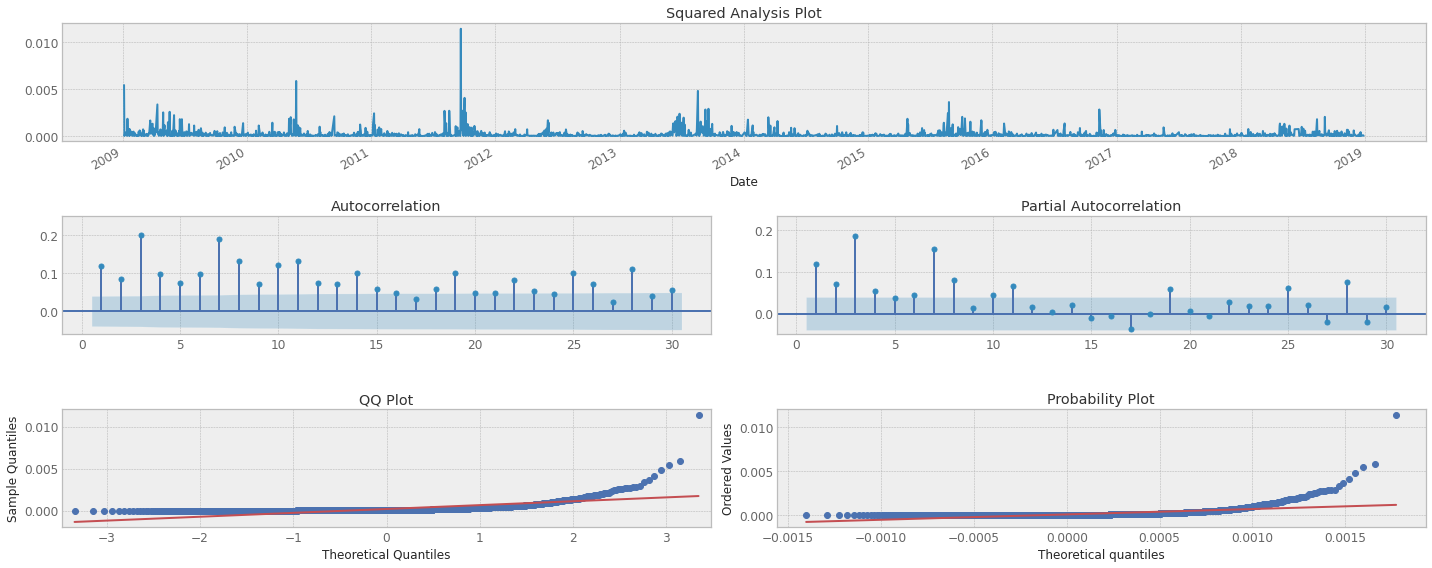

In [6]:
# Autocorrelation Plots
ticker = 'LQ45'
_ = tsplot(in_df[ticker]['log_return'], lags=30)
_ = tsplot(in_df[ticker]['log_return'] ** 2, lags=30, title='Squared Analysis Plot')

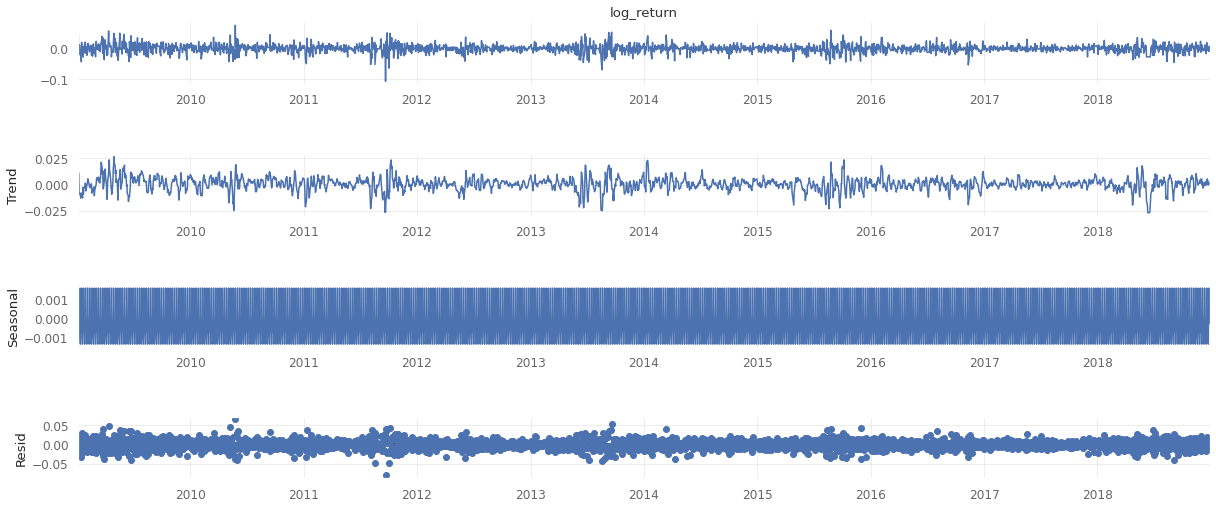

In [7]:
# Extract Trend and Seasonality, and take only residuals
df_buff = in_df[ticker]['log_return'].asfreq('B').fillna(method='ffill')
fig = smt.seasonal_decompose(df_buff, model='additive').plot()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

### Statistical Check

In [8]:
# Statistical Check (Stationarity and Normality)
# TODO - Implement Hurst Exponent and Ornstein-Uhlenbeck (or other mean reverting processes)
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Statistics
tickers = []
length = []

## Stationarity Statistic
adf_p_vals = []
stationary = []

## Normality Statistic
jb_p_vals = []
jb_skews = []
jb_kurtoses = []
normality = []

for ticker in active_tickers:
    tickers.append(ticker)
    length.append(len(in_df[ticker]))
    
    # Stationarity Check
    adf_result = adfuller(in_df[ticker]['log_return'])
    
    adf_p_vals.append(adf_result[1])
    
    ## True if Null rejected, for 1% confidence interval
    s = True if adf_result[0] <= adf_result[4]['1%'] else False 
    stationary.append(s)
    
    # Normality Test
    jb_result = jarque_bera(in_df[ticker]['log_return'])
    
    jb_p_vals.append(jb_result[1])
    jb_skews.append(jb_result[2])
    jb_kurtoses.append(jb_result[3])
    
    ## True if Null NOT rejected, for 1% confidence interval
    n = True if jb_result[1] > 0.01 else False
    normality.append(n)

adf_df = pd.DataFrame({ 
                        'ticker': tickers,
                        'length': length,
                        'adf_p_val': adf_p_vals,
                        'stationary': stationary,
                        'jb_p_val': jb_p_vals,
                        'jb_skew': jb_skews,
                        'jb_kurtosis': jb_kurtoses,
                        'normality': normality
                        })
display(adf_df)

,ticker,length,adf_p_val,stationary,jb_p_val,jb_skew,jb_kurtosis,normality
0,ADRO.JK,2477,0.000000e+00,True,0.000000e+00,0.252292,6.870633,False
1,AMRT.JK,2468,8.686382e-17,True,0.000000e+00,0.565593,13.924337,False
2,ANTM.JK,2477,0.000000e+00,True,0.000000e+00,1.226290,11.429790,False
3,ASII.JK,2477,0.000000e+00,True,1.039670e-304,0.443781,6.574354,False
4,BBCA.JK,2477,0.000000e+00,True,3.469879e-215,-0.045745,6.092062,False
5,BBNI.JK,2477,0.000000e+00,True,0.000000e+00,25.605834,1020.869659,False
6,BBRI.JK,2477,0.000000e+00,True,7.301329e-196,0.092655,5.944942,False
7,BBTN.JK,2239,0.000000e+00,True,0.000000e+00,-0.037573,8.346736,False
8,BFIN.JK,2477,0.000000e+00,True,0.000000e+00,0.844203,14.864221,False
9,BMRI.JK,2477,0.000000e+00,True,4.092180e-237,0.139593,6.235695,False


## Process Modelling

### ARIMA

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

def get_arima_best_order(df_logret, pq_rng=range(5), d_rng=range(2)):
    best_aic = np.inf 
    arima_best_order = None
    arima_best_mdl = None

    for p in tqdm(pq_rng):
        for d in d_rng:
            for q in pq_rng:
                tmp_mdl = smt.ARIMA(df_logret, 
                                    order=(p,d,q)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    arima_best_order = (p, d, q)
                    arima_best_mdl = tmp_mdl
    arima_resid = arima_best_mdl.resid
    print(arima_best_mdl.summary())
    
    return arima_best_order, arima_resid

In [ ]:
# Run ARIMA Fitting
arima_best_order, arima_resid = get_arima_best_order(in_df[ticker]['log_return'])

## Test Ljungbox Fit
lb_pval = ljungbox(arima_resid, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
lb_pval_2 = ljungbox(arima_resid**2, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
print(f'Ljung-Box P-Value on Residual        : {lb_pval}')
print(f'Ljung-Box P-Value on Squared Residual: {lb_pval_2}')

 60%|█████████████████████████████████████████▍                           | 3/5 [00:18<00:12,  6.18s/it]


In [ ]:
# ARIMA Model Summary
_ = tsplot(arima_resid, lags=30)
_ = tsplot(arima_resid ** 2, lags=30, title='Squared Analysis Plot')

# TODO - Find other goodness of fit tests

### GARCH
Source: https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/

In [ ]:
import os
import subprocess

def get_garch_1d_forecast(df_logret, arima_best_order):
    # Prepare Input Files
    ## ARIMA Model Best Order Fle
    with open("arima_model.txt", "w+") as f:
        for item in arima_best_order:
            f.writelines(str(item) + "\n")
    
    ## Log Return File
    df_logret.to_csv("log_ret.csv", index=False)
    
    # Call R Script for fitting and forecasting garch
    garch_script_path = "./20220621_garch.r"
    subprocess.call("/usr/bin/Rscript " + garch_script_path, shell=True)
    
    ## Get garch residuals and forecast
    garch_resid = pd.read_csv("r-garch-resid.csv")['V1']
    
    with open("r-garch-1d-forecast.txt", "r") as f:
        garch_1d_forecast = float(f.read().rstrip('\n'))

    os.remove("arima_model.txt")
    os.remove("log_ret.csv")
    os.remove("r-garch-resid.csv")
    os.remove("r-garch-1d-forecast.txt")
    
    return  garch_1d_forecast, garch_resid

In [ ]:
# Run Garch 1d forecast
garch_1d_forecast, garch_resid = get_garch_1d_forecast(in_df[ticker]['log_return'], arima_best_order)

## Test Ljungbox Fit
lb_pval = ljungbox(garch_resid, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
lb_pval_2 = ljungbox(garch_resid**2, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
print(f'Ljung-Box P-Value on Residual        : {lb_pval}')
print(f'Ljung-Box P-Value on Squared Residual: {lb_pval_2}')

In [ ]:
# GARCH Model Summary
_ = tsplot(garch_resid, lags=30)
_ = tsplot(garch_resid**2, lags=30, title='Squared Analysis Plot')

## Strategy
Source: https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/

If forecast > 0, buy. Else, sell.

In [9]:
# Define Strategy Class
class Strategy():
    '''
    ARIMA-GARCH Simple 1d Forecast Strategy
    https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/
    '''
    def __init__(self, ticker, model_lookback=252):
        # Strategy Parameters
        self.ticker = ticker
        self.model_lookback = model_lookback
    
    def get_arima_best_order(self, df_logret, pq_rng=range(5), d_rng=range(2)):
        best_aic = np.inf 
        arima_best_order = None
        arima_best_mdl = None
        
        try:
            for p in pq_rng:
                for d in d_rng:
                    for q in pq_rng:
                        tmp_mdl = smt.ARIMA(df_logret, 
                                            order=(p,d,q)).fit(method='innovations_mle')
                        tmp_aic = tmp_mdl.aic
                        if tmp_aic < best_aic:
                            best_aic = tmp_aic
                            arima_best_order = (p, d, q)
                            arima_best_mdl = tmp_mdl
            arima_resid = arima_best_mdl.resid
        
        except:
            arima_best_order = None
            arima_resid = None
            print("--ARIMA FAILED")

        return arima_best_order, arima_resid
    
    def get_garch_1d_forecast(self, df_logret, arima_best_order):
        # Prepare Input Files
        ## ARIMA Model Best Order Fle
        with open("arima_model.txt", "w+") as f:
            for item in arima_best_order:
                f.writelines(str(item) + "\n")

        ## Log Return File
        df_logret.to_csv("log_ret.csv", index=False)

        # Call R Script for fitting and forecasting garch
        garch_script_path = "./20220621_garch.r"
        subprocess.call("/usr/bin/Rscript " + garch_script_path, shell=True)

        ## Get garch residuals and forecast
        try:
            garch_resid = pd.read_csv("r-garch-resid.csv")['V1']

            with open("r-garch-1d-forecast.txt", "r") as f:
                garch_1d_forecast = float(f.read().rstrip('\n'))
                
            os.remove("r-garch-resid.csv")
            os.remove("r-garch-1d-forecast.txt")
        
        except:
            garch_resid = None
            garch_1d_forecast = None
            print("--GARCH FAILED")

        os.remove("arima_model.txt")
        os.remove("log_ret.csv")
    
        return  garch_1d_forecast, garch_resid
    
    def get_forecast(self, df_logret):
        # TODO - Maybe add stationarity test here?
        
        arima_best_order, _ = self.get_arima_best_order(df_logret)
        
        if arima_best_order is not None:
            garch_1d_forecast, _ = self.get_garch_1d_forecast(df_logret, arima_best_order)
        else:
            garch_1d_forecast = None
            
        # TODO - Maybe add Ljung Box Test here?
        
        return garch_1d_forecast
        
    def gen_signals(self, df_proc):
        # Signal Rules
        long_signal = lambda f: (f > 0) if f is not None else False
        long_close_signal = lambda f: (f <= 0) if f is not None else False

        # Generate Signals
        last_signal = ''
        df_proc['forecast'] = np.nan
        df_proc['signal'] = ''
        df_proc['signal_ticker'] = ''
        
        assert len(df_proc) > self.model_lookback, \
            f"Length of data {len(df_proc)} is expected to be larger than lookback {self.model_lookback}"
        
        for i in range(self.model_lookback-1, len(df_proc)):
            print(i)
            
            # Forecast 
            ## Note: log_return on the latest index is used to generate signal. The signal is saved on the same index.
            ##       Thus, calculation of final returns takes into account this lag in signal.
            forecast = self.get_forecast(df_proc['log_return'][i-(self.model_lookback-1):i+1])
            df_proc['forecast'][i] = forecast
            
            if i == self.model_lookback:
                df_proc['signal'][i] = ''

            elif last_signal == '':
                if long_signal(forecast):
                    df_proc['signal'][i] = 'long_entry'
                    last_signal = 'long_entry'
                    df_proc['signal_ticker'][i] = self.ticker
                elif long_close_signal(forecast):
                    df_proc['signal'][i] = 'long_close'
                    last_signal = 'long_close'
                    df_proc['signal_ticker'][i] = self.ticker
                else:
                    df_proc['signal'][i] = ''

            elif last_signal == 'long_entry':
                if long_close_signal(forecast):
                    df_proc['signal'][i] = 'long_close'
                    last_signal = 'long_close'
                    df_proc['signal_ticker'][i] = self.ticker
                else:
                    df_proc['signal'][i] = ''

            elif last_signal == 'long_close':
                if long_signal(forecast):
                    df_proc['signal'][i] = 'long_entry'
                    last_signal = 'long_entry'
                    df_proc['signal_ticker'][i] = self.ticker
                else:
                    df_proc['signal'][i] = ''
                    
        return df_proc
    
    def calc_returns(self, df_proc):
        '''
        Calculate returns and cumulative returns per entry on dataframe.
        '''
        last_signal = ''
        last_ticker = ''
        df_proc['strat_return'] = np.nan
        for i in range(0, len(df_proc)):
            if last_signal == 'long_entry':
                df_proc["strat_return"][i] = df_proc["return"][i] 
            elif last_signal == 'long_close':
                df_proc["strat_return"][i] = 0
            else:
                df_proc["strat_return"][i] = 0

            if not(df_proc["signal"][i] == ''):
                last_signal = df_proc["signal"][i] 
                last_ticker = df_proc['signal_ticker'][i]

        df_proc["cum_return"] = (1 + df_proc["strat_return"]).cumprod()
        return df_proc
    
    def run(self):
        # TODO - Filter data based on lookback period
        # TODO - Define data preprocessing steps
        # TODO - Run strategy
        
        pass

In [ ]:
# Run Strategy Backtest
model_lookback = 252
ticker = 'LQ45'
df_proc = out_df[ticker]

s = Strategy(ticker, model_lookback=model_lookback)
s.get_forecast(df_proc['log_return'])
df_proc = s.gen_signals(df_proc)
df_proc = s.calc_returns(df_proc)

In [ ]:
df_proc